## Chapter 10, Example 2b (Additive Noise)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

# Create a figures directory if it doesn't exist
if not os.path.isdir('figures'):
    os.makedirs('figures')

# Parameters
noise_prob = 0.1
n_hidden = 500
batch_size = 128
n_epochs = 50
learning_rate = 0.1

In [3]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 107025078.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27633721.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12837283.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Function: `add_noise`

This function introduces random noise into an image. The process is detailed below:

#### 1. **Noise Generation:**
   - The function `torch.randn(img.size())` generates random numbers following a standard normal distribution (mean = 0, standard deviation = 1). The shape of this noise tensor matches the input image, `img`.
   - These random numbers are then multiplied by `noise_prob`, effectively scaling the noise intensity. The `noise_prob` variable should be a predefined positive float less than 1, indicating the noise level or the probability of noise introduction.

#### 2. **Noise Addition:**
   - The original image, `img`, is added to the generated noise, creating a new tensor `noisy_img` that holds the noisy image. This step doesn't modify the original image but superimposes random noise onto it.

#### 3. **Return Value:**
   - The function returns `noisy_img`, which is the original image with added random noise. This modified image is used as input for subsequent operations, typically in scenarios like training a denoising autoencoder where the model learns to extract significant features while filtering out the noise.


In [11]:
# Add noise to images
def add_noise(img):
    noise = torch.randn(img.size()) * noise_prob
    noisy_img = img + noise
    # Clamping the values of noisy_img to [0, 1]
    clamped_noisy_img = torch.clamp(noisy_img, 0, 1)
    return clamped_noisy_img

## Defining the Autoencoder Class

In the code provided, we are defining a simple autoencoder using PyTorch. Here's a breakdown of its structure and functionality:

### Class Initialization

- The `Autoencoder` class inherits from `nn.Module`, which is a standard practice when defining any neural network model in PyTorch.

- Within the `__init__` method, we define the architecture of our autoencoder. It consists of two main parts: the encoder and the decoder.

    - `self.encoder`: This is a linear layer that reduces the dimensionality of the input data, compressing it into a lower-dimensional space. The layer's size is defined by `n_input` (the size of the input data) and `n_hidden` (the size of the compressed representation).
    
    - `self.decoder`: Another linear layer that reconstructs the original data from its compressed form. The layer's size is the reverse of the encoder, defined by `n_hidden` and `n_input`, respectively.

- The weights of the neural network are initialized following a specific strategy:

    - For the encoder, we initialize the weights with a normal distribution with a mean of `0.0` and a standard deviation of `1 / np.sqrt(n_input)`. This specific choice helps in stabilizing the learning process by controlling the variance of the weights.
    
    - For the decoder, we are using a technique called "tied weights," where the decoder's weights are the transpose of the encoder's weights (`self.encoder.weight.data.T`). This not only reduces the number of parameters in the model but also imposes a form of regularization.

### Forward Pass

- The `forward` method defines the sequence of operations the model performs to generate an output from an input.

    - The input data `x` is first passed through the encoder, compressed, and then the sigmoid activation function is applied. The sigmoid function ensures the output is in the range (0, 1), making the model's behavior more predictable and the learning process more stable.
    
    - The compressed data is then passed through the decoder, attempting to reconstruct the original input. Again, the sigmoid activation function is applied to the output.

- The final output is the reconstructed data from the original input, ideally with reduced noise or removed irrelevant details.

### Model Instantiation

- Finally, we create an instance of the `Autoencoder` class with `28*28` input size (typical for MNIST images, which are 28x28 pixels) and `n_hidden` representing the size of our hidden (compressed) layer. This instance `model` is what we will train and use for encoding/decoding tasks.


In [12]:
# Model
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Linear function
        self.encoder = nn.Linear(n_input, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_input)

        # Weight initialization
        self.encoder.weight.data.normal_(0.0, 1 / np.sqrt(n_input))
        self.decoder.weight.data = self.encoder.weight.data.T  # tied weights

    def forward(self, x):
        x = torch.sigmoid(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

model = Autoencoder(28*28, n_hidden)

In [13]:
def loss_function(y, original):

    # Calculate the mean squared error (MSE) loss
    mse_loss = torch.mean(torch.sum((original - y) ** 2, dim=1))

    return mse_loss

In [14]:
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training
loss_values = []
for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for data in train_loader:
        img, _ = data
        noisy_img = add_noise(img)
        noisy_img = noisy_img.view(noisy_img.size(0), -1)  # flatten
        img = img.view(img.size(0), -1)  # flatten

        # Forward pass
        output = model(noisy_img)
        loss = loss_function(output, img)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/50], Loss: 20.6093
Epoch [2/50], Loss: 9.8424
Epoch [3/50], Loss: 7.3198
Epoch [4/50], Loss: 6.0041
Epoch [5/50], Loss: 5.1705
Epoch [6/50], Loss: 4.5969
Epoch [7/50], Loss: 4.1781
Epoch [8/50], Loss: 3.8611
Epoch [9/50], Loss: 3.6133
Epoch [10/50], Loss: 3.4096
Epoch [11/50], Loss: 3.2417
Epoch [12/50], Loss: 3.1014
Epoch [13/50], Loss: 2.9804
Epoch [14/50], Loss: 2.8783
Epoch [15/50], Loss: 2.7889
Epoch [16/50], Loss: 2.7085
Epoch [17/50], Loss: 2.6382
Epoch [18/50], Loss: 2.5756
Epoch [19/50], Loss: 2.5186
Epoch [20/50], Loss: 2.4669
Epoch [21/50], Loss: 2.4210
Epoch [22/50], Loss: 2.3784
Epoch [23/50], Loss: 2.3395
Epoch [24/50], Loss: 2.3026
Epoch [25/50], Loss: 2.2680
Epoch [26/50], Loss: 2.2395
Epoch [27/50], Loss: 2.2110
Epoch [28/50], Loss: 2.1833
Epoch [29/50], Loss: 2.1594
Epoch [30/50], Loss: 2.1361
Epoch [31/50], Loss: 2.1143
Epoch [32/50], Loss: 2.0925
Epoch [33/50], Loss: 2.0737
Epoch [34/50], Loss: 2.0561
Epoch [35/50], Loss: 2.0380
Epoch [36/50], Loss: 2.0225


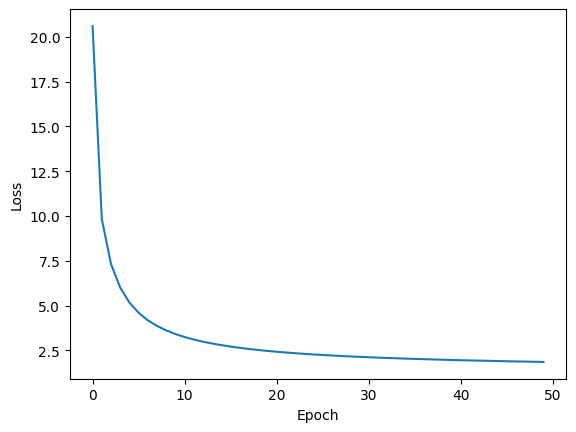

In [15]:
# Plotting the training loss
plt.figure()
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/10.2b_1.png')

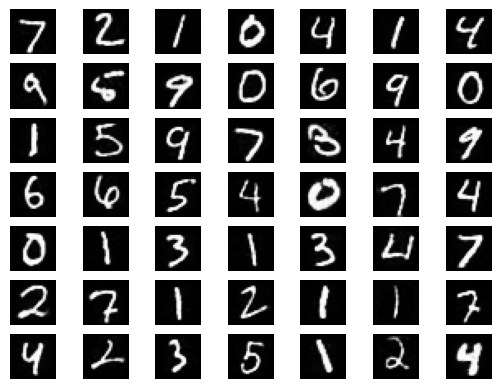

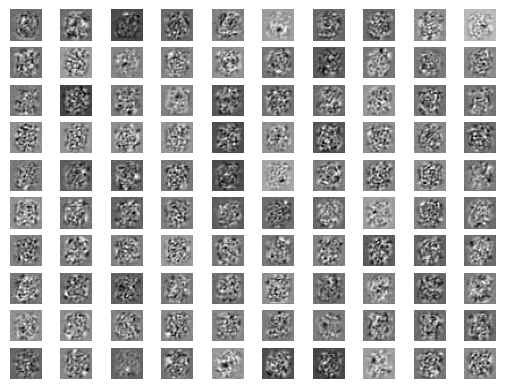

In [16]:
# Visualization
def visualize_output(images, noisy_images, epoch):
    # Plot original images, noisy images, and the reconstructions from the autoencoder
    model.eval()
    with torch.no_grad():
        noisy_images_flat = noisy_images.view(noisy_images.size(0), -1)
        outputs = model(noisy_images_flat).view(-1, 1, 28, 28)
        outputs.clamp_(0, 1)  # Values might be outside [0, 1] range, clamp to ensure valid pixel range

        # Create a grid of images including original, noisy, and reconstructed images
        images = images.cpu()
        noisy_images = noisy_images.cpu()
        outputs = outputs.cpu()

        # Display original images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2b_3.png')

        # Display noisy images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(noisy_images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2b_4.png')

        # Display reconstructed images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(outputs[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2b_5.png')

# Testing with the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
test_images, _ = next(iter(test_loader))

noisy_test_images = add_noise(test_images)
visualize_output(test_images, noisy_test_images, n_epochs)

# Weights visualization
weights = model.encoder.weight.data.view(n_hidden, 28, 28).cpu()
plt.figure()
for i in range(100):  # displaying 100 weights
    plt.subplot(10, 10, i+1)
    plt.imshow(weights[i], cmap="gray")
    plt.axis('off')
plt.savefig('./figures/10.2b_2.png')
